# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Reading the data from SQLITE
1. We are going to classify our data using the attribute "SCORE" from our dataframe
2. SCORE > 3 is classified as Positive review, SCORE < 3 is classified as Negative review
3. Since SCORE = 3 is Neutral, we will not consider those reviews in our classiication

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('C:/Users/Asha/Machine Learning/17. REAL WORLD PROBLEM PREDICT RATING GIVEN PRODUCT REVIEWS ON AMAZON/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

### Data Cleaning: Removing miscategorized data points

1. The products "B00004CI84" and "B00004CXX9" belong to movie category. Since the product name contains the word "Juice", it has been miscategorized under food.

2. "B0002YW26E" is a Pest control product. Miscategorized as food.

3. The products "6641040" and "2841233731" are CookBooks.

In [15]:
# Removing the miscategorized products from the data

final_data=final[~final.ProductId.isin (['B0002YW26E','B00004CI84','B00004CXX9','6641040','2841233731'])]
print("Number of final points in our data",final_data.shape)

Number of final points in our data (363896, 10)


In [16]:
#How many positive and negative reviews are present in our dataset?
print(final_data['Score'].value_counts())

1    306829
0     57067
Name: Score, dtype: int64


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_238 = final_data['Text'].values[238]
print(sent_238)
print("*"*100)

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_238 = re.sub(r"http\S+", "", sent_238)
print(sent_238)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

print(sent_238)
print("*"*100)
soup = BeautifulSoup(sent_238, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

sent_79290 = final_data['Text'].values[79290]
print(sent_79290)
print("*"*100)
sent_79290 = decontracted(sent_79290)
print(sent_79290)

I buy these at Christmas time to stuff for parties.  They are a hit and getting hard to find.  :) Some wait for my tray of stuffed peppers with anticipation, and will be disappointed this year if I can't find them.
****************************************************************************************************
I buy these at Christmas time to stuff for parties.  They are a hit and getting hard to find.  :) Some wait for my tray of stuffed peppers with anticipation, and will be disappointed this year if I can not find them.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
print(text)
print("*"*100)
text = re.sub("\S*\d\S*", "", text).strip()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here? />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
text = re.sub('[^A-Za-z0-9]+', ' ', text)
print(text)

Why is this when the same product is available for here The Victor and traps are unreal of course total fly genocide Pretty stinky but only right nearby 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████| 363896/363896 [02:36<00:00, 2332.14it/s]


In [23]:
preprocessed_reviews[1600]

'cats love product not worry clay getting digested cats family matter one cats getting sick clay tried since natural voila healthy kitties sure may not work new fangled litter boxes not think made scoop litter must sit probably min stay ball love counts plus price awesome usually travel half hours get shipping worth gas travel time thank'

In [24]:
final_data['CleanedText']=preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of review
print(final_data['CleanedText'].values[100])

purchased several different brands liver treats best terms good size pieces small bits little powder


In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████| 363896/363896 [01:43<00:00, 3502.71it/s]


In [26]:
print(final_data['Summary'].values[101])
print("*"*100)
print(preprocessed_summary[101])

My dog would do anything for this treat
****************************************************************************************************
dog would anything treat


In [27]:
final_data['CleanedSummary']=preprocessed_summary #adding a column of CleanedText which displays the data after pre-processing of summary review
print(final_data['CleanedSummary'].values[201])

delicious mildly sweet cookie


In [28]:
final_data['FinalReview']= final_data['CleanedText'] + str(" ") + final_data['CleanedSummary']
print(final_data['CleanedText'].values[100])
print(final_data['CleanedSummary'].values[100])
print("*"*100)
print(final_data['FinalReview'].values[100])

purchased several different brands liver treats best terms good size pieces small bits little powder
good quality
****************************************************************************************************
purchased several different brands liver treats best terms good size pieces small bits little powder good quality


In [29]:
final_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText', 'CleanedSummary', 'FinalReview'],
      dtype='object')

# [4] Applying Multinomial Naive Bayes

In [57]:
# Taking 100k points from our dataset

final_sample = final_data.sample(n=1000)
print(final_sample.shape)
print(final_sample["Score"].shape)

(1000, 13)
(1000,)


In [58]:
word_count= []
for sentence in final_sample['FinalReview'].values:
    total_words= len(sentence.split())
    word_count.append(total_words)
    
print(final_sample['FinalReview'].values[12])
print("The number of words in the above review is: ", word_count[12])

using conditioner great conditioner
The number of words in the above review is:  4


In [59]:
final_sample['word_count']=word_count 
print(final_sample['FinalReview'].values[5])
print("*"*100)
print(final_sample['word_count'].values[5])

texture taste similar stuff gluten rice crackers always weird texture sharp edges hurt mouth perfect hold well quite yummy cheese yum
****************************************************************************************************
21


In [60]:
# Sorting the data based on time

final_sample.sort_values(by='Time', ascending=True, inplace=True)
print(final_sample['Time'].head(1))
print(final_sample['Time'].tail(1))

268850    1120953600
Name: Time, dtype: int64
433652    1351209600
Name: Time, dtype: int64


In [61]:
import sklearn.model_selection as model_selection
from sklearn.neighbors import KNeighborsClassifier

# split the data set into train and test
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(final_sample, final_sample["Score"], shuffle=False,test_size=0.2)

print("No of data points in training dataset", X_tr.shape)
print("No of data points in test dataset", X_test.shape)
print(y_tr.value_counts())

No of data points in training dataset (800, 14)
No of data points in test dataset (200, 14)
1    674
0    126
Name: Score, dtype: int64


In [62]:
print(X_tr['Time'].head(1))
print(X_tr['Time'].tail(1))

print('********************************')

print(X_test['Time'].head(1))
print(X_test['Time'].tail(1))

268850    1120953600
Name: Time, dtype: int64
192233    1338940800
Name: Time, dtype: int64
********************************
58388    1338940800
Name: Time, dtype: int64
433652    1351209600
Name: Time, dtype: int64


## [4.1] Applying Naive Bayes on BOW

In [63]:
#BoW: 
count_vect = CountVectorizer(ngram_range=(1,2)) 
final_counts_train = count_vect.fit_transform(X_tr['FinalReview'].values)
print("The shape of train text BOW vectorizer ",final_counts_train.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_train = hstack((final_counts_train,np.array(X_tr['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_train.get_shape())

The shape of train text BOW after adding word_count  (800, 34019)


In [64]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler(with_mean=False).fit_transform(final_train)

In [65]:
# Balancing the train data
from imblearn.over_sampling import SMOTE 
from collections import Counter

sm = SMOTE(random_state=2)
X_train_bow, y_train_bow = sm.fit_resample(standardized_data_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_bow))

Resampled dataset shape Counter({1: 674, 0: 674})


In [66]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_bow).items()))

Train data before upsampling:  [(0, 126), (1, 674)]
Train data after upsampling :  [(0, 674), (1, 674)]


In [67]:
#BoW: 
final_counts_test = count_vect.transform(X_test['FinalReview'].values)
print("The shape of test text BOW vectorizer ",final_counts_test.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_test = hstack((final_counts_test,np.array(X_test['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_test.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
X_test_bow = StandardScaler(with_mean=False).fit_transform(final_test)

The shape of test text BOW vectorizer  (200, 34018)
The shape of train text BOW after adding word_count  (200, 34019)


MultinomialNB(alpha=1000, class_prior=None, fit_prior=True)
Training Accuracy: 1.0
Test Accuracy: 0.8289536550406117


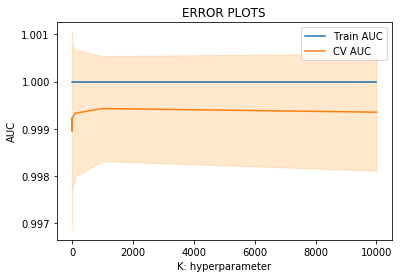

In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = [10 ** x for x in range(-5,5)] 
param_grid = dict(alpha=k_range)

# instantiate the grid
naive = MultinomialNB()
clf = GridSearchCV(naive, param_grid, cv=5,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(X_train_bow, y_train_bow)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(X_train_bow,y_train_bow))
print("Test Accuracy:",clf.score(X_test_bow,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'alpha': 1000}
AUC score on train data:  1.0
AUC score on test data:  0.8289536550406117


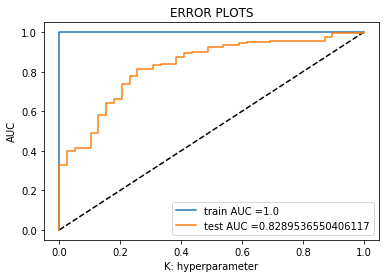

Train confusion matrix
[[674   0]
 [  6 668]]
Test confusion matrix
[[ 24  15]
 [ 20 141]]


In [69]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_alpha = clf.best_params_.get("alpha")

naive = MultinomialNB(alpha= optimal_alpha)
naive.fit(X_train_bow, y_train_bow)

y_pred_proba_train = naive.predict_proba(X_train_bow)[:,1]
y_pred_proba_test = naive.predict_proba(X_test_bow)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_bow, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_bow, naive.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, naive.predict(X_test_bow)))

Confusion matrix for TRAIN data


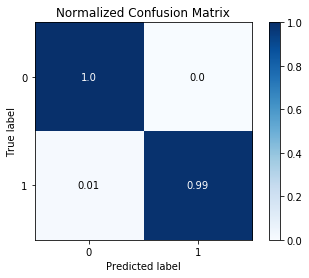

In [70]:
import scikitplot as skplt
print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_bow, naive.predict(X_train_bow), normalize=True)

Confusion matrix for TEST data


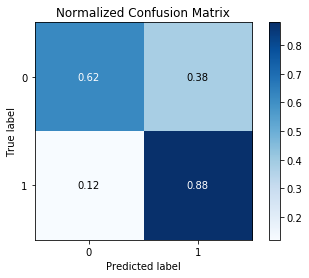

In [71]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, naive.predict(X_test_bow), normalize=True)

In [110]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def feature_importance(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_log_prob_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("The informative features are below: ")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

feature_importance(count_vect, naive)

The informative features are below: 
	-10.4566	ability        			-9.4548	varities not   
	-10.4566	ability grow   			-9.4548	ordered item   
	-10.4566	ability walk   			-9.4548	odd varities   
	-10.4566	able add       			-9.4548	many odd       
	-10.4566	able bread     			-9.4548	like cups      
	-10.4566	able buy       			-9.4548	item wanted    
	-10.4566	able convince  			-9.4548	impressed many 
	-10.4566	able cover     			-9.4548	different coffees
	-10.4566	able cut       			-9.4548	coffees not    
	-10.4566	able drink     			-9.4589	weird get      


In [114]:
w = count_vect.get_feature_names()
coeff_df=sorted(zip(naive.feature_log_prob_[0],w))
featu = pd.DataFrame(coeff_df)
print(featu.head(10).to_string(index=False))
print(featu.tail(10).to_string(index=False))

0              1
-10.456626        ability
-10.456626   ability grow
-10.456626   ability walk
-10.456626       able add
-10.456626     able bread
-10.456626       able buy
-10.456626  able convince
-10.456626     able cover
-10.456626       able cut
-10.456626     able drink
0                  1
-9.458855          weird get
-9.454845        coffees not
-9.454845  different coffees
-9.454845     impressed many
-9.454845        item wanted
-9.454845          like cups
-9.454845           many odd
-9.454845       odd varities
-9.454845       ordered item
-9.454845       varities not


## [4.2] Applying Naive Bayes on TFIDF

In [63]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_tr = tf_idf_vect.fit_transform(X_tr['CleanedText'].values)
print("The shape of train TFIDF vectorizer ",tf_idf_tr.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_train_tfidf = hstack((tf_idf_tr,np.array(X_tr['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_train_tfidf.get_shape())

# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
x_scaled_tr = StandardScaler(with_mean=False).fit_transform(final_train_tfidf)

The shape of train TFIDF vectorizer  (80000, 1328163)
The shape of train text BOW after adding word_count  (80000, 1328164)


In [64]:
# Balancing the train data
from imblearn.over_sampling import SMOTE 
from collections import Counter

sm = SMOTE(random_state=2)
X_train_tfidf, y_train_tfidf = sm.fit_resample(x_scaled_tr, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf))

Resampled dataset shape Counter({0: 67654, 1: 67654})


In [65]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf).items()))

Train data before upsampling:  [(0, 12346), (1, 67654)]
Train data after upsampling :  [(0, 67654), (1, 67654)]


In [66]:
tf_idf_test = tf_idf_vect.transform(X_test['CleanedText'].values)
print("The shape of test TFIDF vectorizer ",tf_idf_test.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_test_tfidf = hstack((tf_idf_test,np.array(X_test['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_test_tfidf.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
X_test_tfidf = StandardScaler(with_mean=False).fit_transform(final_test_tfidf)

The shape of test TFIDF vectorizer  (20000, 1328163)
The shape of train text BOW after adding word_count  (20000, 1328164)


MultinomialNB(alpha=10000, class_prior=None, fit_prior=True)
Training Accuracy: 0.9997175912156343
Test Accuracy: 0.886032568049695


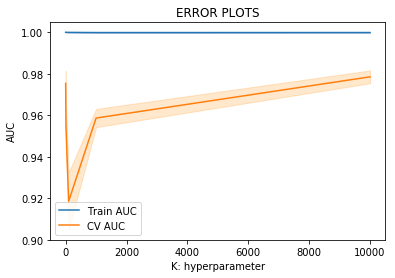

In [73]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = [10 ** x for x in range(0,5)] 
param_grid = dict(alpha=k_range)

# instantiate the grid
naive = MultinomialNB()
clf = GridSearchCV(naive, param_grid, cv=5,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(X_train_tfidf, y_train_tfidf)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(X_train_tfidf,y_train_tfidf))
print("Test Accuracy:",clf.score(X_test_tfidf,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'alpha': 10000}
AUC score on train data:  0.9997175912156343
AUC score on test data:  0.886032568049695


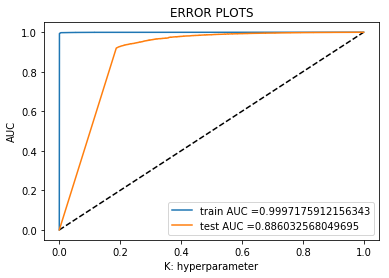

Train confusion matrix
[[67300   354]
 [  151 67503]]
Test confusion matrix
[[ 2209  1238]
 [  445 16108]]


In [74]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_alpha = clf.best_params_.get("alpha")

naive = MultinomialNB(alpha= optimal_alpha)
naive.fit(X_train_tfidf, y_train_tfidf)

y_pred_proba_train = naive.predict_proba(X_train_tfidf)[:,1]
y_pred_proba_test = naive.predict_proba(X_test_tfidf)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_tfidf, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf, naive.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, naive.predict(X_test_tfidf)))

In [76]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def feature_importance(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_log_prob_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("The informative features are below: ")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

feature_importance(tf_idf_vect, naive)

The informative features are below: 
	-14.1200	aa cell        			-12.2523	not            
	-14.1200	aa coffee      			-12.8100	would          
	-14.1200	aa expiration  			-12.8466	like           
	-14.1200	aa half        			-12.8782	taste          
	-14.1200	aa not         			-12.9442	product        
	-14.1200	aa offering    			-13.0084	disappointed   
	-14.1200	aa pods        			-13.0108	bad            
	-14.1200	aa rich        			-13.0203	one            
	-14.1200	aa root        			-13.0456	no             
	-14.1200	aa stated      			-13.0714	would not      


In [ ]:
import scikitplot as skplt
print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_bow, naive.predict(X_train_bow), normalize=True)

In [ ]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, naive.predict(X_test_bow), normalize=True)

# [5] Conclusions

In [77]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyper parameter", "Train AUC", "Test AUC"]

x.add_row(["BOW", 10000, 0.99, 0.91])
x.add_row(["TFIDF", 10000, 0.99, 0.89])


print(x)

+------------+-----------------+-----------+----------+
| Vectorizer | Hyper parameter | Train AUC | Test AUC |
+------------+-----------------+-----------+----------+
|    BOW     |      10000      |    0.99   |   0.91   |
|   TFIDF    |      10000      |    0.99   |   0.89   |
+------------+-----------------+-----------+----------+
